# Introduction 

Title: Applying analysis techniques and machine learning model on Lending Club dataset <br>
Data From: https://www.kaggle.com/wendykan/lending-club-loan-data <br>
Made By- Udbhav Naryani (RA1711003030230), Daksh Kumar Sharma (RA1711003030195)


In [0]:
# libraries used on this notebook
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#from wordcloud import WordCloud, STOPWORDS

from matplotlib import rcParams
rcParams['figure.figsize'] = 8,6

# Sklearn
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics 

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA 
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV

from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
warnings.filterwarnings('ignore')

### Load data
Handy function for data loading.


In [0]:
def load_data(filename):
    """Read from local file"""
    return pd.read_csv(filename + ".csv", low_memory=False)

In [0]:
for_analysis = load_data(r"C:\Users\wizard19999\Downloads\loan")
for_ml = for_analysis.copy()

### Making DataFrame Faster
We will convert columns that have less than 150 unique values to <b>categorical</b>. 

In [0]:
def reduce_memory_usage(data):
    for x in data.columns:
        n = data[x].dtypes
        if n == "object":
            cat = data[x].nunique()
            if cat < 150:
                data[x] = data[x].astype("category")

In [0]:
reduce_memory_usage(for_analysis)

### Drop useless columns
We'll filter out the columns with more than 80% NULL values and then drop those columns from the DataFrame. 

In [0]:
def PercentageMissin(Dataset):
    if isinstance(Dataset,pd.DataFrame):
        adict={} 
        column = []
        for col in Dataset.columns:
            adict[col]=(np.count_nonzero(Dataset[col].isnull())*100)/len(Dataset[col])
            if adict[col] > 80:
                del adict[col]
            else:
                column.append(col)
        Dataset = Dataset.loc[:, column]
        return Dataset
    else:
        raise TypeError("can only be used with panda dataframe")

In [0]:
for_analysis = PercentageMissin(for_analysis) 

In [0]:
for_analysis.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN


## Section 1
### Analysis

### Question 1: What kind of interest rate are borrowers paying?

Output: the common interest rate borrowers are paying is <b>13.24%</b><br>


In [0]:
for_analysis = for_analysis[for_analysis.int_rate.notnull()]
for_analysis.int_rate.describe()

count    887379.000000
mean         13.246740
std           4.381867
min           5.320000
25%           9.990000
50%          12.990000
75%          16.200000
max          28.990000
Name: int_rate, dtype: float64

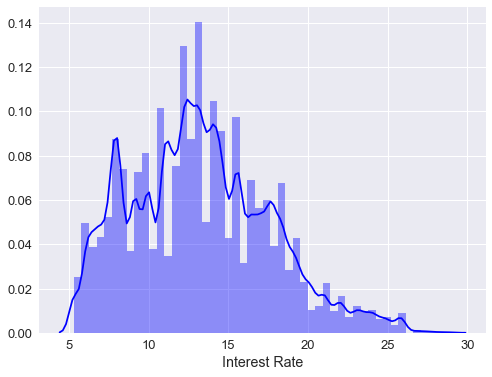

In [0]:

sns.distplot(for_analysis.int_rate, axlabel = "Interest Rate", color="blue")

### Question 2: How long are the loan terms?

<b>Output:</b> about 70 percent of all borrowers choose 36 months loan terms.

In [0]:
for_analysis.term.value_counts(1)

 36 months    0.699955
 60 months    0.300045
Name: term, dtype: float64

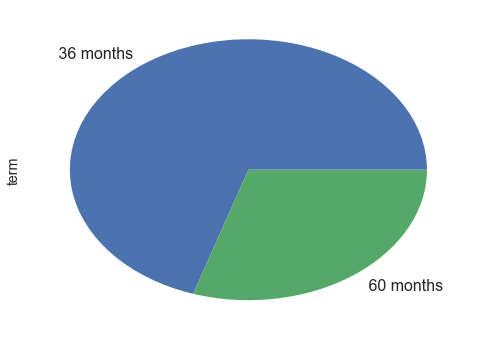

In [0]:
for_analysis.term.value_counts(1).plot(kind="pie", fontsize=16)

### Question 3: How much are people borrowing?

<b>Output:</b> the average amount people borrow is $14,755.

In [0]:
for_analysis.loan_amnt.describe()

count    887379.000000
mean      14755.264605
std        8435.455601
min         500.000000
25%        8000.000000
50%       13000.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64

### Question 4: for what purpose?

<b>Output:</b> most people are borrowing money for 'debt', 'small business', and 'credit card'

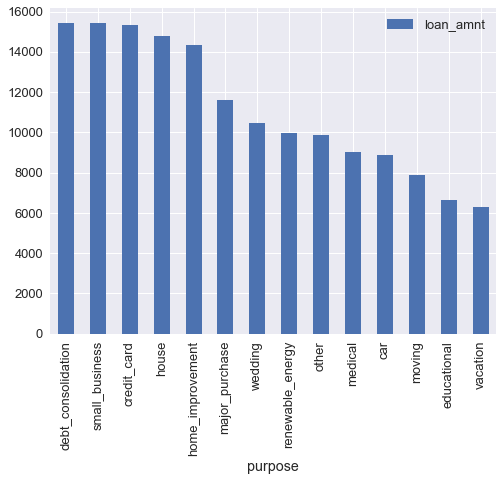

In [0]:
for_analysis.groupby('purpose').agg(
    {'loan_amnt':'mean'}).sort_values('loan_amnt', ascending=False).plot(kind='bar')

### Crossbat table by loan purpose and loan status

In [0]:
#Exploring the loan_status x purpose
purp_loan= ['purpose', 'loan_status']
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(for_analysis[purp_loan[0]], for_analysis[purp_loan[1]]).style.background_gradient(cmap = cm)

loan_status,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
purpose,,,,,,,,
car,461,4937,10,3249,40,81,15,70
credit_card,7895,149835,233,42521,1150,2071,381,2096
debt_consolidation,27891,356239,790,121572,3998,4796,1510,7419
educational,88,1,0,334,0,0,0,0
home_improvement,2340,34980,47,12803,367,493,137,662
house,297,1854,7,1399,37,37,15,61
major_purchase,897,10308,14,5491,125,184,51,207
medical,591,5324,15,2321,56,91,17,125
moving,440,3121,11,1634,43,52,23,90


### Crossbat table by loan status and grade

In [0]:
loan_grade = ['loan_status', 'grade']
cm = sns.light_palette("orange", as_cmap=True)
pd.crosstab(for_analysis[loan_grade[0]], for_analysis[loan_grade[1]]).style.background_gradient(cmap = cm)

grade,A,B,C,D,E,F,G
loan_status,,,,,,,
Charged Off,2625,9604,12790,10683,6416,3027,864
Current,103322,171735,171175,91984,47061,13589,2913
Default,47,198,360,312,201,79,22
Fully Paid,39769,66815,53159,30514,13306,4880,1268
In Grace Period,365,1240,1887,1405,908,354,94
Issued,1448,2529,2472,1185,593,194,39
Late (16-30 days),134,410,678,569,368,155,43
Late (31-120 days),492,2004,3339,2890,1852,768,246


### Crosstab table by term and loan status

In [0]:
loan_grade = ['term', 'loan_status']
cm = sns.light_palette("orange", as_cmap=True)
pd.crosstab(for_analysis[loan_grade[0]], for_analysis[loan_grade[1]]).style.background_gradient(cmap = cm)

loan_status,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
term,,,,,,,,
36 months,29732,402848,715,169364,3975,5982,1483,7026
60 months,16277,198931,504,40347,2278,2478,874,4565


# Section 2
## Machine Learning


In [0]:
def remove_percent_sign(v):
    if isinstance(v, float):
        return v[:-1]
    else:
        TypeError("Required float type")

In [0]:
def loan_format(data):
    if isinstance(data, pd.DataFrame):
        data = data[(data["loan_status"] == "Fully Paid") | 
                       (data["loan_status"] == "Charged Off")]
        onehotd = {"Fully Paid":0, "Charged Off":1}
        data = data.replace({"loan_status": onehotd})
        return data
    else:
        TypeError("Required dataframe type")

In [0]:
for_ml = loan_format(for_ml)
for_ml.shape

(252971, 74)

This will the features we'll be using for our machine learning models

In [0]:
features_used = ['funded_amnt','emp_length','annual_inc','home_ownership','grade',
                 'last_pymnt_amnt', 'mort_acc', 'pub_rec', 'int_rate', 'open_acc','num_actv_rev_tl',
                 'mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op','bc_util','bc_open_to_buy',
                 'avg_cur_bal','acc_open_past_24mths','loan_status']

for_ml = for_ml.loc[:, features_used]
for_ml = for_ml.reset_index(drop=True)
for_ml.shape

(252971, 18)

In [0]:

ready_data = for_ml.copy()

In [0]:
ready_data.head()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,5000.0,10+ years,24000.0,RENT,B,171.62,NaN,0.0,10.65,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2500.0,< 1 year,30000.0,RENT,C,119.66,NaN,0.0,15.27,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2400.0,10+ years,12252.0,RENT,C,649.91,NaN,0.0,15.96,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,10000.0,10+ years,49200.0,RENT,C,357.48,NaN,0.0,13.49,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,5000.0,3 years,36000.0,RENT,A,161.03,NaN,0.0,7.90,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [0]:
ready_data['loan_status'].value_counts()

0    207723
1     45248
Name: loan_status, dtype: int64

In [0]:
def data_encoding(data):
    if isinstance(data, pd.DataFrame):
        data['grade'] = data['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})
        data["home_ownership"] = data["home_ownership"].map({"MORTGAGE":6,"RENT":5,"OWN":4,"OTHER":3,"NONE":2,"ANY":1})
        data["emp_length"] = data["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, regex = True)
        data["emp_length"] = data["emp_length"].apply(lambda x:int(x))
        data.dropna(how='any')
        return data.head()
    else:
        TypeError("Required DataFrame")

In [0]:
new_data = ready_data.copy()

In [0]:
data_encoding(new_data)

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,5000.0,10,24000.0,5,6,171.62,NaN,0.0,10.65,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2500.0,1,30000.0,5,5,119.66,NaN,0.0,15.27,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2400.0,10,12252.0,5,5,649.91,NaN,0.0,15.96,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,10000.0,10,49200.0,5,5,357.48,NaN,0.0,13.49,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,5000.0,3,36000.0,5,7,161.03,NaN,0.0,7.90,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0



We'll apply heatmap on features we select to see if they contain missing values, that will tell us what features to drop.

In [0]:
def plot_missing(data):
    sns.set(font_scale = 1.25) #font size
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.xticks(range(len(data.columns)), data.columns, rotation=60)
    plt.show()

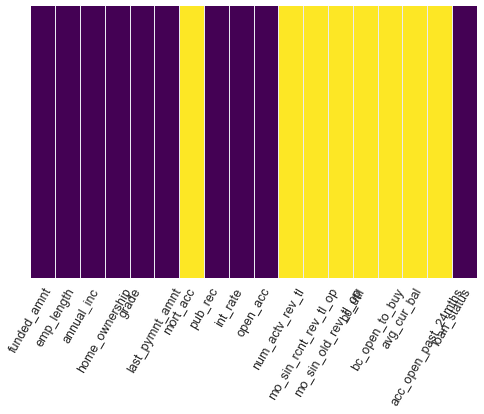

In [0]:
plot_missing(new_data)

### We can remove these features


In [0]:
def delete_cols(data):
    if isinstance(data, pd.DataFrame):
        del_col = ['num_actv_rev_tl','mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op',
                   'bc_util','bc_open_to_buy','avg_cur_bal','acc_open_past_24mths', 'mort_acc']
        return data.drop(del_col, axis=1, inplace=True)
    else:
        TypeError("Required dataframe")

In [0]:
delete_cols(new_data)

In [0]:
new_data.head()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,pub_rec,int_rate,open_acc,loan_status
0,5000.0,10,24000.0,5,6,171.62,0.0,10.65,3.0,0
1,2500.0,1,30000.0,5,5,119.66,0.0,15.27,3.0,1
2,2400.0,10,12252.0,5,5,649.91,0.0,15.96,2.0,0
3,10000.0,10,49200.0,5,5,357.48,0.0,13.49,10.0,0
4,5000.0,3,36000.0,5,7,161.03,0.0,7.90,9.0,0


In [0]:
new_data = new_data.fillna(new_data.mean(),inplace = True)
new_data.head() 

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,pub_rec,int_rate,open_acc,loan_status
0,5000.0,10,24000.0,5,6,171.62,0.0,10.65,3.0,0
1,2500.0,1,30000.0,5,5,119.66,0.0,15.27,3.0,1
2,2400.0,10,12252.0,5,5,649.91,0.0,15.96,2.0,0
3,10000.0,10,49200.0,5,5,357.48,0.0,13.49,10.0,0
4,5000.0,3,36000.0,5,7,161.03,0.0,7.90,9.0,0


In [0]:
scl = preprocessing.StandardScaler() #instance of preprocessing
fields = new_data.columns.values[:-1]
data_clean = pd.DataFrame(scl.fit_transform(new_data[fields]), columns = fields)
data_clean['loan_status'] = new_data['loan_status']
data_clean['loan_status'].value_counts()

0    207723
1     45248
Name: loan_status, dtype: int64

In [0]:
loanstatus_0 = new_data[new_data["loan_status"]==0]
loanstatus_1 = new_data[new_data["loan_status"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=5500)
subset_of_loanstatus_1 = loanstatus_1.sample(n=5500)
new_data = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
new_data = new_data.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",new_data.shape)
new_data.head()

Current shape of dataset : (11000, 10)


,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,pub_rec,int_rate,open_acc,loan_status
0,14000.0,5,55000.0,6,7,11898.00,0.0,6.03,7.0,0
1,18000.0,10,64000.0,5,7,567.30,0.0,8.39,12.0,1
2,9000.0,10,25000.0,6,5,311.95,1.0,14.99,15.0,1
3,12000.0,6,53000.0,6,5,283.22,0.0,14.64,7.0,1
4,7300.0,10,23420.0,6,5,7309.57,0.0,14.65,8.0,0


### Before and After feature scaling


In [0]:
up_to_date = new_data.copy()

In [0]:
def before_scale(data):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize= (15,7))
    ax1.set_title("Before Scaling")
    for col in data.columns:
        sns.kdeplot(data[col], ax=ax1)
        
    
    ax2.set_title("After Scaling")
    scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
    scaled_df = scaler.fit_transform(data)
    scaled_df = pd.DataFrame(scaled_df, columns=data.columns)
    for col2 in data.columns:
        sns.kdeplot(scaled_df[col2], ax = ax2)
        
    plt.show()

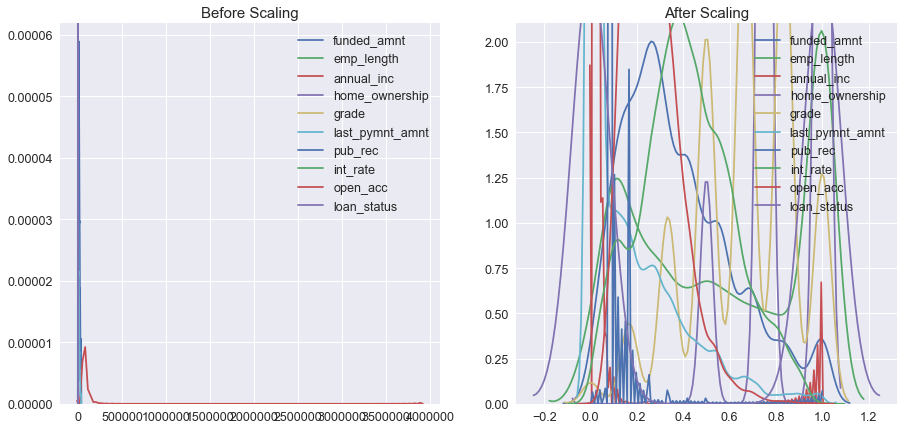

In [0]:
before_scale(up_to_date)

In [0]:
scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
scaled_df = scaler.fit_transform(new_data)
scaled_df = pd.DataFrame(scaled_df, columns=new_data.columns)

In [0]:
scaled_df.head()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,pub_rec,int_rate,open_acc,loan_status
0,0.382353,0.5,0.013070,1.00,1.000000,0.333434,0.000000,0.031472,0.166667,0.0
1,0.500000,1.0,0.015380,0.75,1.000000,0.015898,0.000000,0.136082,0.285714,1.0
2,0.235294,1.0,0.005370,1.00,0.666667,0.008742,0.083333,0.428635,0.357143,1.0
3,0.323529,0.6,0.012557,1.00,0.666667,0.007937,0.000000,0.413121,0.166667,1.0
4,0.185294,1.0,0.004964,1.00,0.666667,0.204846,0.000000,0.413564,0.190476,0.0


In [0]:
scaled_df.corr()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,pub_rec,int_rate,open_acc,loan_status
funded_amnt,1.000000,0.153906,0.326314,0.156881,-0.242948,0.394216,-0.065934,0.242924,0.200333,0.062768
emp_length,0.153906,1.000000,0.084972,0.155378,-0.030427,0.098921,0.015011,0.038838,0.064936,-0.020095
annual_inc,0.326314,0.084972,1.000000,0.139920,0.002665,0.190627,-0.003931,-0.018504,0.117236,-0.072754
home_ownership,0.156881,0.155378,0.139920,1.000000,0.047148,0.113614,0.028995,-0.051424,0.117534,-0.062726
grade,-0.242948,-0.030427,0.002665,0.047148,1.000000,-0.000286,-0.056591,-0.951226,-0.048533,-0.268097
last_pymnt_amnt,0.394216,0.098921,0.190627,0.113614,-0.000286,1.000000,0.007407,-0.020669,0.106498,-0.574344
pub_rec,-0.065934,0.015011,-0.003931,0.028995,-0.056591,0.007407,1.000000,0.054162,-0.017690,-0.005905
int_rate,0.242924,0.038838,-0.018504,-0.051424,-0.951226,-0.020669,0.054162,1.000000,0.055616,0.292658
open_acc,0.200333,0.064936,0.117236,0.117534,-0.048533,0.106498,-0.017690,0.055616,1.000000,0.008805
loan_status,0.062768,-0.020095,-0.072754,-0.062726,-0.268097,-0.574344,-0.005905,0.292658,0.008805,1.000000


In [0]:
scaled_df.shape

(11000, 10)

#### train_test_split function

We'll split our data into train and test set using the sckit-learn library and specifically the 'train_test_split' function.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df.iloc[:, :-1], scaled_df.iloc[:, -1], 
                                                    test_size = .3, random_state = 42)
print(">>>> X_train size: {}".format(X_train.shape))
print(">>>> X_test size: {}".format(X_test.shape))
print()
print(">>>> y_train size: {}".format(y_train.shape))
print(">>>> st size: {}".format(y_test.shape))

>>>> X_train size: (7700, 9)
>>>> X_test size: (3300, 9)

>>>> y_train size: (7700,)
>>>> st size: (3300,)


### ROC Curve Function


In [0]:
def plot_roc(truth, pred, title):
    fpr, tpr, _ = metrics.roc_curve(truth, pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color = c, lw = lw, label = title + " (AUC = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'slateblue', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')

### Confusion Matrix Function


In [0]:
def plot_c_matrix(model, normalize=False):
    c_matrix = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.cool
    title = "Confusion Matrix"
    if normalize:
        c_matrix = c_matrix.astype('float') / c_matrix.sum(axis=1)[:, np.newaxis]
        c_matrix = np.around(c_matrix, decimals=3)
        
    plt.imshow(c_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = c_matrix.max() / 2.0
    
    for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
        plt.text(j, i, c_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if c_matrix[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Random Forest
We'll use the random forest algorithm to fit a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

In [0]:
rand_forest = RandomForestClassifier(criterion = 'gini', random_state = 42)
maxFeatures  = range(1, scaled_df.shape[1]-1)
param_dt = dict(max_features = maxFeatures )
rand = RandomizedSearchCV(rand_forest, param_dt, cv = 10, scoring = 'accuracy', n_iter = len(maxFeatures), random_state = 42)

X = scaled_df.iloc[:, :-1].values
y = scaled_df.iloc[:, -1].values
rand.fit(X, y)
mean_score = [x.mean_validation_score for x in rand.grid_scores_]
print(rand.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


In [0]:
rf = RandomForestClassifier(bootstrap = True, criterion = 'gini', max_features = rand.best_estimator_.max_features, 
                            random_state = 42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
pred_prob = rf.predict_proba(X_test)[:, 1]
acc_score = accuracy_score(y_test, pred)
roc_score = metrics.roc_auc_score(y_test, pred)
print(acc_score)

0.886363636364


### ROC Curve and Confusion Matrix

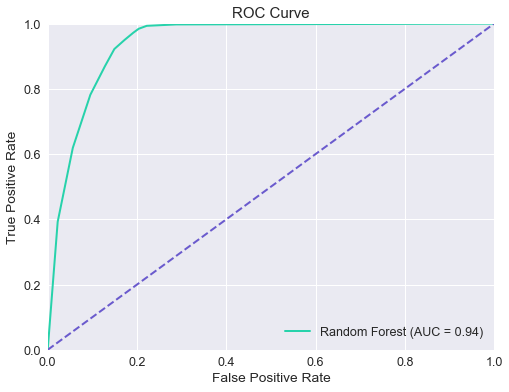

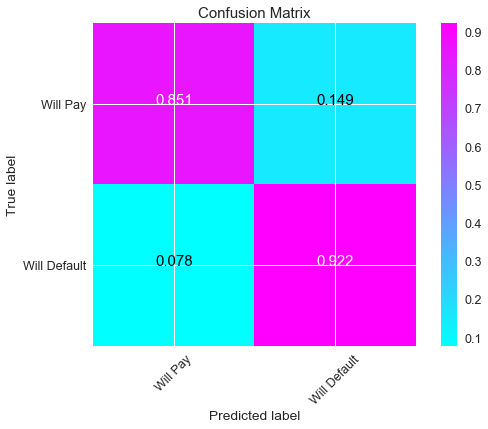

In [0]:
plot_roc(y_test, pred_prob, 'Random Forest')
plt.show()
plt.figure(figsize=(8,6))
plot_c_matrix(pred, normalize = True)
plt.show()